In [1]:
!python --version

Python 3.7.16


In [1]:
from Agent import Agent

import torch

import numpy as np
import pandas as pd

import os
import sys
os.chdir("..")
from rice_nego import Rice

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def create_agent(env, state, id):
    return Agent(len(state[id]['features']), env.action_space[id], env.num_regions, id = id)

In [3]:
envs = [Rice(id = i, region_yamls_filename='2_region_yamls', num_discrete_action_levels=5) for i in range(5)]
initial_state = envs[0].reset()
agents = [create_agent(envs[0], initial_state, agent_id) for agent_id in range(envs[0].num_regions)]

In [4]:
def step1(agents, envs, states):
    
    # Get actions in the shape [agent_id, {'proposals' : [env_id, proposal], 'promise' : [env_id, promise]}]
    actions = [agent.make_proposals([state[agent.id] for state in states]) for agent in agents]
        
    # Transform actions to [env_id, {agent_id, : {'proposals' : proposal, 'promise', 'promise'}}]
    actions = [
        {
            agent_id : {
                'proposals' : actions[agent_id]['proposals'][env_id],
                'promises' : actions[agent_id]['promises'][env_id]
            }
            for agent_id in range(len(agents))
        }
        for env_id in range(len(envs))
    ]
    
    # Pass the proposals to the environments
    states = [env.register_proposals(actions[i]) for i, env in enumerate(envs)]
    return states

In [5]:
def step2(agents, envs, states):
    
    # Get actions in the shape [agent_id, env_id, decision]
    actions = [agent.make_decisions([state[agent.id] for state in states]) for agent in agents]
    
    # Transform actions to [env_id, {agent_id : decision}]
    actions = [
        {
            agent_id : actions[agent_id][env_id]
            for agent_id in range(len(agents))
        }
        for env_id in range(len(envs))
    ]
    
    # Pass the decisions to the environments
    states = [env.register_decisions(actions[i]) for i, env in enumerate(envs)]
    return states

In [6]:
def act(agents, envs, states):
    
    actions = {agent_id : agents[agent_id].act([state[agent_id] for state in states]) 
               for agent_id in range(len(agents))}
    
    actions = [
        {
            agent_id : actions[agent_id][env_id]
            for agent_id in range(len(agents))
        }
        for env_id in range(len(envs))
    ]
    
    states, rewards, _, _ = zip(*[env.step(actions[i]) for (i, env) in enumerate(envs)])
    
    return states, rewards

In [7]:
episode_length = envs[0].episode_length
negotiation_steps = envs[0].max_negotiation_steps

# The terminal states are the same every time
is_terminals = np.zeros(len(envs) * negotiation_steps, dtype = bool)
is_terminals[range(negotiation_steps - 1, len(is_terminals), negotiation_steps)] = True

for epoch in tqdm(range(20)):
    
    for batch in range(2):
        states = [env.reset() for env in envs]
        for t in range(episode_length):
            
            for agent in agents:
                agent.reset_negotiation_hs()

            for step in range(negotiation_steps):
                states = step1(agents, envs, states)
                states = step2(agents, envs, states)
                
                for agent in agents:
                    agent.nets['proposalNet'].buffer.rewards.extend(
                        [env.global_negotiation_state['rewards_proposals'][t][step][agent.id] for env in envs]
                    )
                    agent.nets['proposalNet'].buffer.is_terminals.extend(is_terminals)
                    
                    agent.nets['decisionNet'].buffer.rewards.extend(
                        [env.global_negotiation_state['rewards_decisions'][t][step][agent.id] for env in envs]
                    )
                    agent.nets['decisionNet'].buffer.is_terminals.extend(is_terminals)
            
            states, rewards = act(agents, envs, states)
            all_rewards_actions = np.array([list(reward.values()) for reward in rewards])
            
            for agent in agents:
                agent.nets['activityNet'].buffer.rewards.extend(all_rewards_actions[:, agent.id])
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
            
    for agent in agents:
        agent.update()
    b

  0%|                                                                                                               | 0/20 [00:03<?, ?it/s]


NameError: name 'b' is not defined

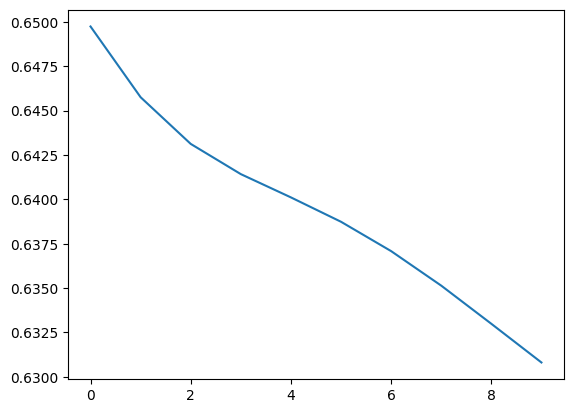

In [10]:
plt.plot(agents[1].nets['proposalNet'].loss_collection)